# Sentiment Analysis

In [42]:
from __future__ import print_function
%matplotlib inline

from IPython.display import Image, display
from io import BytesIO
import matplotlib.pyplot as plt

#import nltk
#from nltk.tokenize import word_tokenize
#from nltk.stem import WordNetLemmatizer

#import numpy as numpy
import random
#import pickle
from collections import Counter
import codecs
import tensorflow as tf
import np
import time

import os
from os.path import join, exists

import pandas as pd
import pydot_ng as pydot
import graphviz
from ggplot import *

from keras.utils.data_utils import get_file
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding, Dropout, Flatten, LSTM
from keras.optimizers import RMSprop, Adam, SGD, Adagrad

#nltk.download('punkt')
#nltk.download('wordnet')
#totalLinesToRead = 100
#lemmatizer = WordNetLemmatizer()

# Data load

The first step when building machine learning model is getting your data into the proper form to feed into the model. 


In [43]:
with open('./data/netflix-train-pos', 'r') as f:
    positive_train_txt = f.read()
with open('./data/netflix-train-neg', 'r') as f:
    negative_train_txt = f.read()

In [44]:
print("The positive data size: {}".format(len(positive_train_txt)))
print("The negative data size: {}".format(len(negative_train_txt)))

The positive data size: 16855330
The negative data size: 16302491


## Basic prediction
Let's assume we will say to all data positive.


In [45]:
print("Basic/Benchmark Accuracy: " + str(float(len(positive_train_txt)) / (len(positive_train_txt) + len(negative_train_txt))))

Basic/Benchmark Accuracy: 0.50833647965


# Download GloVe


In [46]:
data_folder = './datasets'
glove = 'glove.6B'
glove_filename = glove + '.zip'
glove_url = 'http://nlp.stanford.edu/data/' + glove_filename
embedding_dim = 300
glove_loc = join(data_folder, glove_filename)

if not exists(glove_loc):
    print('Download %s' % glove_filename)
    get_file(glove_filename, glove_url, cache_dir='.', extract=True)

glove_filename = os.path.join(data_folder, glove + '.' + str(embedding_dim) + 'd.txt')

embeddings = {}

print('Extract %s' % glove_filename)
with open(glove_filename, 'r') as f:
    for line in f:
        values = line.split(' ')
        word = values[0]
        embedding = np.asarray(values[1:], dtype='float32')
        embeddings[word] = embedding
        
print('Embeddings size: %d' % len(embeddings))

Extract ./datasets/glove.6B.300d.txt
Embeddings size: 400000


# Data preprocessing

First, let's remove all punctuation. Then get all the text without the newlines and split it into individual words.

In [47]:
from string import punctuation

def get_reviews(text):
    #all_text = ''.join([c for c in text if c not in punctuation])
    reviews = text.split('\n')
    return reviews # TAKE first 1000 to make it fast

positive_train = get_reviews(positive_train_txt)
negative_train = get_reviews(negative_train_txt)

positive_label = np.full((len(positive_train), 2), [1, 0])
negative_label = np.full((len(negative_train), 2), [0, 1])

train = np.concatenate((positive_train, negative_train), axis=0)
labels = np.concatenate((positive_label, negative_label), axis=0)

# shuffle
c = np.c_[train.reshape(len(train), -1), labels.reshape(len(labels), -1)]
np.random.shuffle(c)

train = c[:, :train.size//len(train)].reshape(train.shape)
labels = c[:, train.size//len(train):].reshape(labels.shape)

del c
del positive_label
del negative_label

print("Train shape: \t\t{}".format(train.shape))
print("Label shape: \t\t{}".format(labels.shape))

Train shape: 		(25000,)
Label shape: 		(25000, 2)


## Encoding the words
Create dictinaries that map the words in the vocaulary to integers. Then we can convert each of our reviews into integers sos they can be passed into the network.

In [48]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train)
train_ints = tokenizer.texts_to_sequences(train)
word_index = tokenizer.word_index

print('Found %s unique tokens.' % len(word_index))

Found 88584 unique tokens.


## Prepare Word Embeddings

In [50]:
from collections import defaultdict
NUM_WORDS = len(embeddings)
words_len = min(NUM_WORDS, len(word_index))
word_embedding_matrix = np.random.random((words_len + 1, embedding_dim))
k = 0
for word, i in word_index.items():
    if i >= NUM_WORDS:
        continue
    embedding_vector = embeddings.get(word)
    if embedding_vector is not None:
        word_embedding_matrix[i] = embedding_vector
        k += 1
        
del embeddings

In [51]:
print('Null word embeddings: %d' % (np.sum(np.sum(word_embedding_matrix, axis=1) == 0) - 1))
print('Found %d' % k)
print('Total: %d' % len(word_embedding_matrix))

Null word embeddings: -1
Found 60150
Total: 88585


## Sentence length

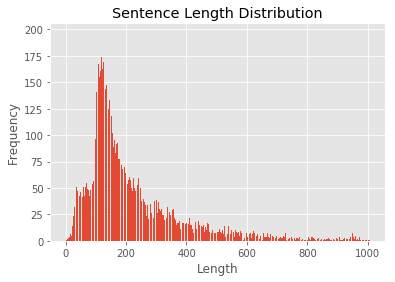

In [52]:
from collections import defaultdict

max_word_count_text = 0
text_count = defaultdict(int)
for sentence in train_ints:
    max_word_count_text = max(max_word_count_text, len(sentence))
    text_count[len(sentence)] += 1
    
mpl_fig = plt.figure()
ax = mpl_fig.add_subplot(111)

ax.bar(range(len(text_count)), text_count.values())

plt.title("Sentence Length Distribution")
plt.xlabel("Length")
plt.ylabel("Frequency")
plt.show()

In [53]:
print('Max word sentence: %d' % max_word_count_text)

Max word sentence: 2493


Some issues here. We seem to have one review with zero length. And, the maximum review length is way too many steps for our RNN. Let's truncate to 200 steps. For reviews shorter than 200, we'll pad with 0s. For reviews longer than 200, we can truncate them to the first 200 characters.

Turns out its the final review that has zero length. But that might not always be the case, so let's make it more general.


In [54]:
#train_ints = [train_ints[ii] for ii in non_zero_idx]
#labels = np.array([labels[ii] for ii in non_zero_idx])

Now, create an array features that contains the data we'll pass to the network. The data should come from review_ints, since we want to feed integers to the network. Each row should be 200 elements long. For reviews shorter than 200 words, left pad with 0s. That is, if the review is ['best', 'movie', 'ever'], [117, 18, 128] as integers, the row will look like [0, 0, 0, ..., 0, 117, 18, 128]. For reviews longer than 200, use on the first 200 words as the feature vector.

In [55]:
seq_len = 100
features = sequence.pad_sequences(train_ints, maxlen = seq_len)

In [56]:

print('One sample')

print('Text: ')
print( train[1] )

print('Word sequence: ')
print( train_ints[1] )

print('Pad: ')
print( features[1] )

print('Label: ')
print( labels[1] )

del train

One sample
Text: 
I saw this movie originally in the theater, when I was 10. Even at that age the 'humor' was mildly insulting to my adolescent intelligence.<br /><br />In the past, whenever I would see Ed Begley Jr. or jeff Goldblum I would cringe and start to feel very uncomfortable and even slightly sad. Until I was reminded of the existence of this movie today, I was unsure why I felt that way. Apparently I blocked my memory of this movie yet my negative feelings towards two of the perpetrators remained. Apparently I forgot that I saw this movie but subconsciously mourned the pieces of my soul that had been stolen, nay EATEN by the creators of this inhuman work.<br /><br />I haven't been brave enough to try watching it as an adult. I imagine that as part of the healing process that I should probably look at confronting this childhood fear so that I can *truly* put it behind me. Some regression therapy and / or hypnosis might not be a bad idea either.
Word sequence: 
[10, 216, 11, 1

# Training, Validation, Test

With our data in nice shape, we'll split it into training, validation, and test sets. Do not foget to shuffle it.

In [57]:
split_idx = int(len(features)*0.8)
train_x, val_x = features[:split_idx], features[split_idx:]
train_y, val_y = labels[:split_idx], labels[split_idx:]

test_idx = int(len(val_x)*0.5)
val_x, test_x = val_x[:test_idx], val_x[test_idx:]
val_y, test_y = val_y[:test_idx], val_y[test_idx:]

print("\t\t\tFeature Shapes:")
print("Train set: \t\t{}".format(train_x.shape)) 
print("Validation set: \t{}".format(val_x.shape))
print("Test set: \t\t{}".format(test_x.shape))

print("Train lable: \t\t{}".format(train_y.shape))


			Feature Shapes:
Train set: 		(20000, 100)
Validation set: 	(2500, 100)
Test set: 		(2500, 100)
Train lable: 		(20000, 2)


## Create Sentiment Neural Network

In [58]:
def createModel(hidden_size, drop_size, output_activation):
    model = Sequential()

    model.add(Dense(hidden_size, activation='relu', input_dim = seq_len))
    
    if drop_size > 0.0:
        model.add(Dropout(drop_size))

    model.add(Dense(hidden_size, activation='relu'))

    if drop_size > 0.0:
        model.add(Dropout(drop_size))

    model.add(Dense(hidden_size, activation='relu'))

    if drop_size > 0.0:
        model.add(Dropout(drop_size))

    model.add(Dense(2, activation=output_activation))

    optimizer = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)

    model.compile(loss = 'binary_crossentropy',
                  optimizer = optimizer,
                  metrics = ['accuracy'])
    return model




In [59]:
def createEmbeddedModel(hidden_size, drop_size):
    model = Sequential()
    
    model.add(Embedding(words_len + 1,
                     embedding_dim,
                     weights = [word_embedding_matrix],
                     input_length = seq_len,
                     trainable = False,
                     name = 'embedding'))
    if drop_size > 0.0:
        model.add(Dropout(drop_size))
        
    model.add(LSTM(seq_len, dropout=0.2, recurrent_dropout=0.2))
    
    model.add(Dense(hidden_size, activation='relu', input_dim = seq_len, name="hidden_1"))
    
    if drop_size > 0.0:
        model.add(Dropout(drop_size))

    model.add(Dense(hidden_size, activation='relu', name="hidden_2"))

    if drop_size > 0.0:
        model.add(Dropout(drop_size))

    model.add(Dense(hidden_size, activation='relu', name="hidden_3"))

    if drop_size > 0.0:
        model.add(Dropout(drop_size))
        
    #model.add(Flatten())  # [[ [1, 2], [2, 2] ], ....]  -> [[ 1, 2, 2, 2], ....]

    model.add(Dense(2, activation='softmax', name="output"))

    optimizer = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)

    model.compile(loss = 'binary_crossentropy',
                  optimizer = optimizer,
                  metrics = ['accuracy'])
    return model

## Train model

In [60]:
batch_size = 20
epochs = 5

models = {}

#models['model_200_drop_0.1_softmax'] = createModel(200, 0.1, 'softmax')
#models['model_200_drop_0.1_sigmoid'] = createModel(200, 0.1, 'sigmoid')

#models['model_400_drop_0.1'] = createModel(400, 0.1)
#models['model_600_drop_0.1'] = createModel(600, 0.1)
#models['model_200_no_drop'] = createModel(200, 0)
#models['model_400_no_drop'] = createModel(400, 0)
#models['model_600_no_drop'] = createModel(600, 0)

models['model_200_embedded_drop_0_netflix_ALL'] = createEmbeddedModel(200, 0)

results = []
for name, model in models.items():  
    start_time = time.time()
    print('')
    print('Start learning %s at %d' % (name, start_time))
    print('Epochs: %d' % epochs)
    print('Batch size: %d' % batch_size)

    history = model.fit(train_x, train_y,
              batch_size = batch_size,
              epochs = epochs,
              validation_data=(val_x, val_y))

    end_time = time.time()
    average_time_per_epoch = (end_time - start_time) / epochs
    results.append((history, average_time_per_epoch))
    print('Time: %d' % (end_time - start_time))


Start learning model_200_embedded_drop_0_netflix_ALL at 1521742294
Epochs: 5
Batch size: 20
Train on 20000 samples, validate on 2500 samples
Epoch 1/5
20000/20000 [==============================] - 299s 15ms/step - loss: 0.5201 - acc: 0.7304 - val_loss: 0.4236 - val_acc: 0.8028
Epoch 2/5
20000/20000 [==============================] - 310s 16ms/step - loss: 0.3805 - acc: 0.8257 - val_loss: 0.3641 - val_acc: 0.8380
Epoch 3/5
20000/20000 [==============================] - 277s 14ms/step - loss: 0.3341 - acc: 0.8544 - val_loss: 0.3712 - val_acc: 0.8336
Epoch 4/5
20000/20000 [==============================] - 272s 14ms/step - loss: 0.3007 - acc: 0.8693 - val_loss: 0.3562 - val_acc: 0.8472
Epoch 5/5
20000/20000 [==============================] - 219s 11ms/step - loss: 0.2682 - acc: 0.8856 - val_loss: 0.3557 - val_acc: 0.8468
Time: 1380


In [61]:
model.save('model_100_embedded_drop_0_netflix_ALL.h5')

In [62]:
for name, model in models.items():  
    
    score, acc = model.evaluate(test_x, test_y,
                                batch_size=batch_size)
    print('Model:', name)
    print('  Test score:', score)
    print('  Test accuracy:', acc)

2500/2500 [==============================] - 11s 4ms/step
Model: model_200_embedded_drop_0_netflix_ALL
  Test score: 0.305043537796
  Test accuracy: 0.866400000095


# Training Results

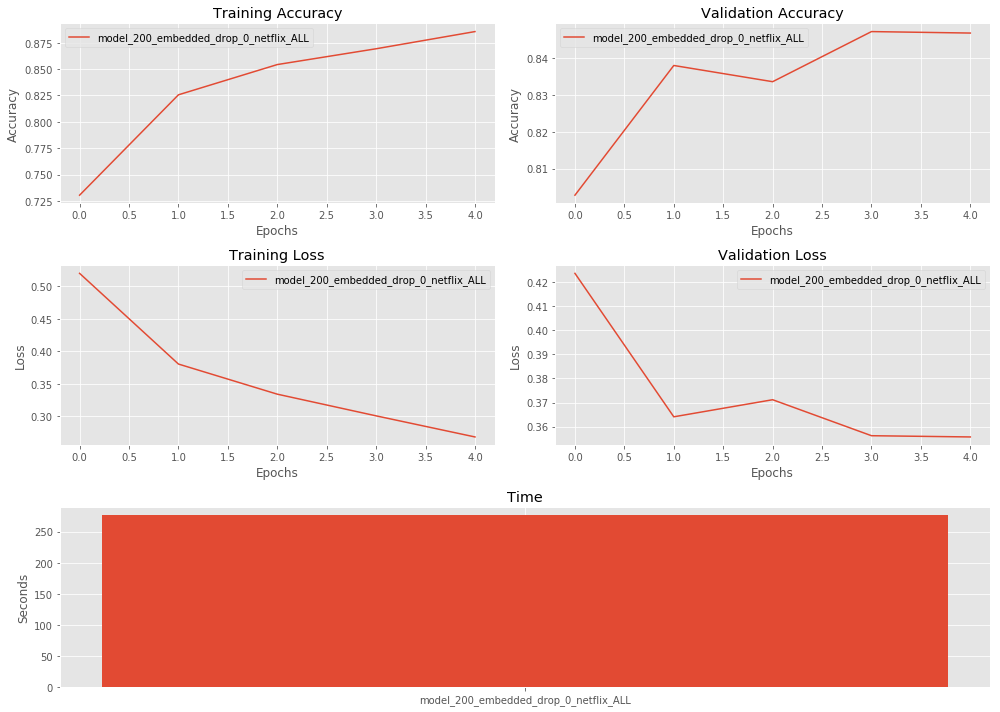

In [63]:

plt.style.use('ggplot')
plt.figure(figsize=(14, 10))#, dpi=100)

ax1 = plt.subplot2grid((3, 2), (0, 0))
ax1.set_title('Training Accuracy')
ax1.set_ylabel('Accuracy')
ax1.set_xlabel('Epochs')

ax2 = plt.subplot2grid((3, 2), (1, 0))
ax2.set_title('Training Loss')
ax2.set_ylabel('Loss')
ax2.set_xlabel('Epochs')

ax3 = plt.subplot2grid((3, 2), (0, 1))
ax3.set_title('Validation Accuracy')
ax3.set_ylabel('Accuracy')
ax3.set_xlabel('Epochs')

ax4 = plt.subplot2grid((3, 2), (1, 1))
ax4.set_title('Validation Loss')
ax4.set_ylabel('Loss')
ax4.set_xlabel('Epochs')

ax5 = plt.subplot2grid((3, 2), (2, 0), rowspan=1, colspan=2)
ax5.set_title('Time')
ax5.set_ylabel('Seconds')

for mode, result in zip(models, results):
    ax1.plot(result[0].epoch, result[0].history['acc'], label=mode)
    ax2.plot(result[0].epoch, result[0].history['loss'], label=mode)
    ax3.plot(result[0].epoch, result[0].history['val_acc'], label=mode)
    ax4.plot(result[0].epoch, result[0].history['val_loss'], label=mode)
    
ax1.legend()
ax2.legend()

ax3.legend()
ax4.legend()

ax5.bar(np.arange(len(results)), [x[1] for x in results], tick_label = models.keys(), align='center')

plt.tight_layout()
plt.show()

In [64]:
for name, model in models.items():
    classes = model.predict(test_x, batch_size=20)
    
print(classes)

[[ 0.94268298  0.05731701]
 [ 0.99896383  0.00103612]
 [ 0.02653761  0.9734624 ]
 ..., 
 [ 0.59167725  0.40832281]
 [ 0.99164683  0.00835326]
 [ 0.1524141   0.84758586]]


In [65]:
predicted = np.argmax(classes, axis=1)
real = np.argmax(test_y, axis=1)

#print(predicted)
#print(real)

pos = 0
neg = 0

for i in xrange(len(predicted)):
    if predicted[i] == real[i]:
        if predicted[i] == 1:
            pos += 1
        else:
            neg += 1
            
print("positive matched " + str(pos))
print("negative matched " + str(neg))

#(predicted == real).all()

len(classes)

total_pos = 0
total_neg = 0

for i in xrange(len(predicted)):
    if predicted[i] == 1:
        total_pos += 1
    else:
        total_neg += 1
        
print("positive total " + str(total_pos))
print("negative total " + str(total_neg))

positive matched 1090
negative matched 1076
positive total 1260
negative total 1240
